In [1]:
import pandas as pd
import numpy as np
import random
from transformers import AdamW, get_linear_schedule_with_warmup
import os
import torch
from sklearn.metrics.pairwise import cosine_similarity
from torch import nn
import torch.optim as optim
import warnings
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
import tokenizers
import re
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from transformers import RobertaTokenizer
from transformers import RobertaModel, RobertaConfig
import string
import nltk
import tqdm
import time
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import datetime


warnings.filterwarnings('ignore')

In [2]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [3]:
df = pd.read_csv("../input/sst2data/SST-2/train.tsv", delimiter='\t', header=None, names=['sentence', 'label'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

sentences = df.sentence.values
labels = df.label.values

sentences_train = np.delete(sentences, (0), axis=0)
#print(sentences)
labels = np.delete(labels, (0), axis=0)
#print(labels)


labels.dtype
labels_train=labels.astype(int)
labels_train

Number of training sentences: 67,350



array([0, 0, 1, ..., 1, 1, 0])

In [4]:
# Load the RoBERTa tokenizer.
print('Loading RobertaTokenizer...')
tokenizer = RobertaTokenizer.from_pretrained('roberta-large', do_lower_case=True)

Loading RobertaTokenizer...


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [5]:
def preprocess(sentences,labels):
    
    # Print the original sentence.
    print(' Original: ', sentences[0])

    # Print the sentence split into tokens.
    print('Tokenized: ', tokenizer.tokenize(sentences[0]))

    # Print the sentence mapped to token ids.
    print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))
    
    max_len = 0

    # For every sentence...
    for sent in sentences:

        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.encode(sent, add_special_tokens=True)

        # Update the maximum sentence length.
        max_len = max(max_len, len(input_ids))

    print('Max sentence length: ', max_len)
    
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 67,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    # Print sentence 0, now as a list of IDs.
    print('Original: ', sentences[0])
    print('Token IDs:', input_ids[0])

    return input_ids,attention_masks,labels

In [6]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
input_ids, attention_masks, labels=preprocess(sentences_train,labels_train)

dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

 Original:  hide new secretions from the parental units 
Tokenized:  ['hide', 'Ġnew', 'Ġsecret', 'ions', 'Ġfrom', 'Ġthe', 'Ġparental', 'Ġunits', 'Ġ']
Token IDs:  [37265, 92, 3556, 2485, 31, 5, 20536, 2833, 1437]


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max sentence length:  67
Original:  hide new secretions from the parental units 
Token IDs: tensor([    0, 37265,    92,  3556,  2485,    31,     5, 20536,  2833,  1437,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1])
60,614 training samples
6,735 validation samples


In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
params = {
    'device': device,
    #'debug': False,
    #'checkpoint': '../input/roberta-base',
    'output_logits': 1024,
    'max_len': 256,
    'batch_size': 32,
    'dropout': 0.1,
    'num_workers': 2,
    'val_samples' : 500,
    'temperature' : 0.3,
    'lambda' : 0.9,
    'num_train_samples' : 100,
    'num_val_samples' : 500,
    'learning_rate' : 1e-5,
    'num_epochs' : 5
}
scl_model_path = r"./scl_model.pt"
cross_model_path = r"./cross_model.pt"

In [8]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size# Evaluate with this batch size.
        )

In [9]:
class Model_Classifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels, dropout):
        super(Model_Classifier, self).__init__()
        # Instantiate BERT model
        self.bert = RobertaModel.from_pretrained('roberta-large')
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_labels = num_labels
        self.dropout = dropout

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding_dim, self.hidden_dim),
            # nn.Dropout(self.dropout),
            #nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_dim, self.num_labels)
        )

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits, last_hidden_state_cls

In [10]:
def initialize_model():
    """Initialize the Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    model_classifier = Model_Classifier(1024, 20, 2, dropout=0.1)

    # Tell PyTorch to run the model on GPU
    model_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(model_classifier.parameters(),
                      lr=1e-5,  # Default learning rate
                      eps=1e-8  # Default epsilon value
                      )

    return model_classifier, optimizer

In [11]:
def scl(temp, embedding, label):
    """calculate the contrastive loss
    """
    # cosine similarity between embeddings
    cosine_sim = cosine_similarity(embedding, embedding)
    # remove diagonal elements from matrix
    dis = cosine_sim[~np.eye(cosine_sim.shape[0], dtype=bool)].reshape(cosine_sim.shape[0], -1)
    # apply temprature to elements
    dis = dis / temp
    cosine_sim = cosine_sim / temp
    # apply exp to elements
    dis = np.exp(dis)
    cosine_sim = np.exp(cosine_sim)

    # calculate row sum
    row_sum = []
    for i in range(len(embedding)):
        row_sum.append(sum(dis[i]))
    # calculate outer sum
    contrastive_loss = 0
    for i in range(len(embedding)):
        n_i = label.tolist().count(label[i]) - 1
        inner_sum = 0
        # calculate inner sum
        for j in range(len(embedding)):
            if label[i] == label[j] and i != j:
                inner_sum = inner_sum + np.log(cosine_sim[i][j] / row_sum[i])
        if n_i != 0:
            contrastive_loss += (inner_sum / (-n_i))
        else:
            contrastive_loss += 0
    return contrastive_loss

In [12]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
def train(model, train_dataloader, validation_dataloader, criterion, optimizer, num_epochs, is_scl = False):
    
    from transformers import get_linear_schedule_with_warmup
    # Create the learning rate scheduler.
    total_steps = len(train_dataloader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []
    train_accuracy = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, num_epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 64 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            logits, hidden_state = model(b_input_ids, b_input_mask)
            
            preds = torch.argmax(logits, dim = 1).flatten()

            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            train_accuracy.append(accuracy)
            
            loss = criterion(logits, b_labels)
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            if is_scl:
                contrastive_loss = scl(params['temperature'], hidden_state.cpu().detach().numpy(), b_labels)
                #print('contrastive_loss:',contrastive_loss)
                final_loss = params['lambda'] * contrastive_loss + (1 - params['lambda']) * loss
                #print('final_loss:',final_loss)
                total_train_loss += final_loss.item()
            else:
                total_train_loss += loss.item()
            

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        total_accuracy = np.mean(train_accuracy)

        print(f'Average training loss after epoch {num_epochs} is : {avg_train_loss}')
        print(f'Average training accuracy after epoch {num_epochs} is : {total_accuracy}')
            

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels
            
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                logits, hidden_state = model(b_input_ids, b_input_mask)
                
            loss = criterion(logits, b_labels)    

            if is_scl:
                contrastive_loss = scl(params['temperature'], hidden_state.cpu().detach().numpy(), b_labels)
                #print('contrastive_loss:',contrastive_loss)
                final_loss = params['lambda'] * contrastive_loss + (1 - params['lambda']) * loss
                #print('final_loss:',final_loss)
                total_eval_loss += final_loss.item()
            else:
                total_eval_loss += loss.item()
                
            

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    if is_scl:
        torch.save(model.state_dict(), scl_model_path)
    else:
        torch.save(model.state_dict(), cross_model_path)

In [14]:

# initialize model
bert_classifier, optimizer = initialize_model()
criterion = nn.CrossEntropyLoss()
is_scl = False
train(bert_classifier, train_dataloader, validation_dataloader, criterion, optimizer, params['num_epochs'], is_scl)


Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



======== Epoch 1 / 5 ========
Training...
  Batch    64  of  1,895.    Elapsed: 0:00:48.
  Batch   128  of  1,895.    Elapsed: 0:01:34.
  Batch   192  of  1,895.    Elapsed: 0:02:21.
  Batch   256  of  1,895.    Elapsed: 0:03:08.
  Batch   320  of  1,895.    Elapsed: 0:03:55.
  Batch   384  of  1,895.    Elapsed: 0:04:42.
  Batch   448  of  1,895.    Elapsed: 0:05:28.
  Batch   512  of  1,895.    Elapsed: 0:06:15.
  Batch   576  of  1,895.    Elapsed: 0:07:02.
  Batch   640  of  1,895.    Elapsed: 0:07:49.
  Batch   704  of  1,895.    Elapsed: 0:08:36.
  Batch   768  of  1,895.    Elapsed: 0:09:22.
  Batch   832  of  1,895.    Elapsed: 0:10:09.
  Batch   896  of  1,895.    Elapsed: 0:10:56.
  Batch   960  of  1,895.    Elapsed: 0:11:43.
  Batch 1,024  of  1,895.    Elapsed: 0:12:29.
  Batch 1,088  of  1,895.    Elapsed: 0:13:16.
  Batch 1,152  of  1,895.    Elapsed: 0:14:03.
  Batch 1,216  of  1,895.    Elapsed: 0:14:50.
  Batch 1,280  of  1,895.    Elapsed: 0:15:36.
  Batch 1,344  of

In [15]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("../input/sst2data/SST-2/dev.tsv", delimiter='\t', header=None, names=['sentence', 'label'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

sentences = df.sentence.values
labels = df.label.values

sentences_val = np.delete(sentences, (0), axis=0)
#print(sentences)
labels = np.delete(labels, (0), axis=0)
#print(labels)


labels.dtype
labels_val=labels.astype(int)
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_val:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 67,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_val)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 873



In [16]:
# Prediction on test set
def evaluate(model_path,prediction_dataloader):
    print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

    model = Model_Classifier(1024, 20, 2, dropout=0.1).cuda()
    model.load_state_dict(torch.load(model_path))
    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions , true_labels = [], []
    all_logits=[]

    # Predict 
    for batch in prediction_dataloader:
        batch = tuple(t.to(device) for t in batch)

      # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
        with torch.no_grad():
          # Forward pass, calculate logit predictions
            logits, hidden_state = model(b_input_ids, b_input_mask)
            all_logits.append(logits)

      # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    print('    DONE.')
    return predictions,true_labels

Predicting labels for 872 test sentences...


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


    DONE.


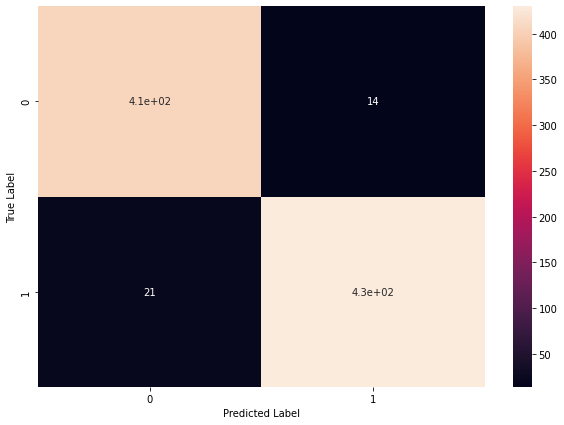

Accuracy: 0.9598623853211009
Recall: [0.95093458 0.96846847]
Precision: [0.96674584 0.95343681]
F1_score: [0.95877503 0.96089385]


In [17]:
predictions,true_labels=evaluate(cross_model_path,prediction_dataloader)
# Combine the results across all batches. 
flat_predictions_raw = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions_raw, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

cm = confusion_matrix(flat_predictions, flat_true_labels)
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Accuracy
print(f'Accuracy: {accuracy_score(flat_true_labels, flat_predictions)}')

# Recall
print(f'Recall: {recall_score(flat_true_labels, flat_predictions, average=None)}')

# Precision
print(f'Precision: {precision_score(flat_true_labels, flat_predictions, average=None)}')

# F1_score
print(f'F1_score: {f1_score(flat_true_labels, flat_predictions, average=None)}')



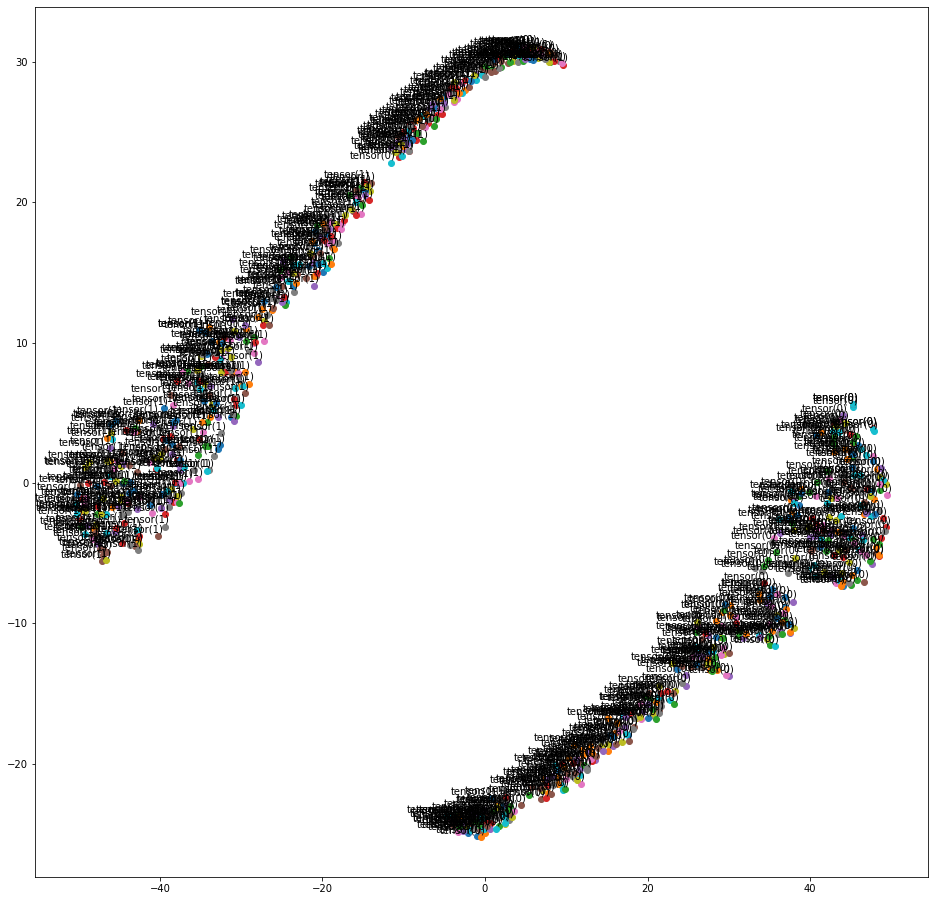

In [18]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(flat_predictions_raw)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In [19]:
# initialize model
bert_classifier, optimizer = initialize_model()
is_scl = True
criterion = nn.CrossEntropyLoss()
train(bert_classifier, train_dataloader, validation_dataloader,criterion, optimizer, params['num_epochs'], is_scl)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



======== Epoch 1 / 5 ========
Training...
  Batch    64  of  1,895.    Elapsed: 0:00:51.
  Batch   128  of  1,895.    Elapsed: 0:01:41.
  Batch   192  of  1,895.    Elapsed: 0:02:32.
  Batch   256  of  1,895.    Elapsed: 0:03:22.
  Batch   320  of  1,895.    Elapsed: 0:04:13.
  Batch   384  of  1,895.    Elapsed: 0:05:04.
  Batch   448  of  1,895.    Elapsed: 0:05:54.
  Batch   512  of  1,895.    Elapsed: 0:06:45.
  Batch   576  of  1,895.    Elapsed: 0:07:36.
  Batch   640  of  1,895.    Elapsed: 0:08:27.
  Batch   704  of  1,895.    Elapsed: 0:09:17.
  Batch   768  of  1,895.    Elapsed: 0:10:08.
  Batch   832  of  1,895.    Elapsed: 0:10:59.
  Batch   896  of  1,895.    Elapsed: 0:11:49.
  Batch   960  of  1,895.    Elapsed: 0:12:40.
  Batch 1,024  of  1,895.    Elapsed: 0:13:31.
  Batch 1,088  of  1,895.    Elapsed: 0:14:21.
  Batch 1,152  of  1,895.    Elapsed: 0:15:12.
  Batch 1,216  of  1,895.    Elapsed: 0:16:02.
  Batch 1,280  of  1,895.    Elapsed: 0:16:53.
  Batch 1,344  of

Predicting labels for 872 test sentences...


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


    DONE.


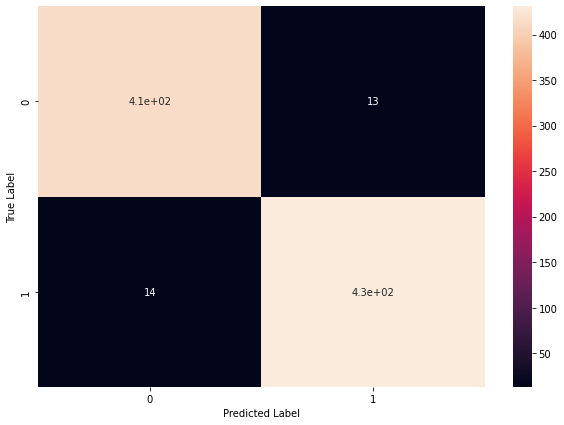

Accuracy: 0.9690366972477065
Recall: [0.96728972 0.97072072]
Precision: [0.96955504 0.96853933]
F1_score: [0.96842105 0.9696288 ]


In [20]:
predictions,true_labels=evaluate(scl_model_path,prediction_dataloader)
# Combine the results across all batches. 
flat_predictions_raw = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions_raw, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

cm = confusion_matrix(flat_predictions, flat_true_labels)
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Accuracy
print(f'Accuracy: {accuracy_score(flat_true_labels, flat_predictions)}')

# Recall
print(f'Recall: {recall_score(flat_true_labels, flat_predictions, average=None)}')

# Precision
print(f'Precision: {precision_score(flat_true_labels, flat_predictions, average=None)}')

# F1_score
print(f'F1_score: {f1_score(flat_true_labels, flat_predictions, average=None)}')



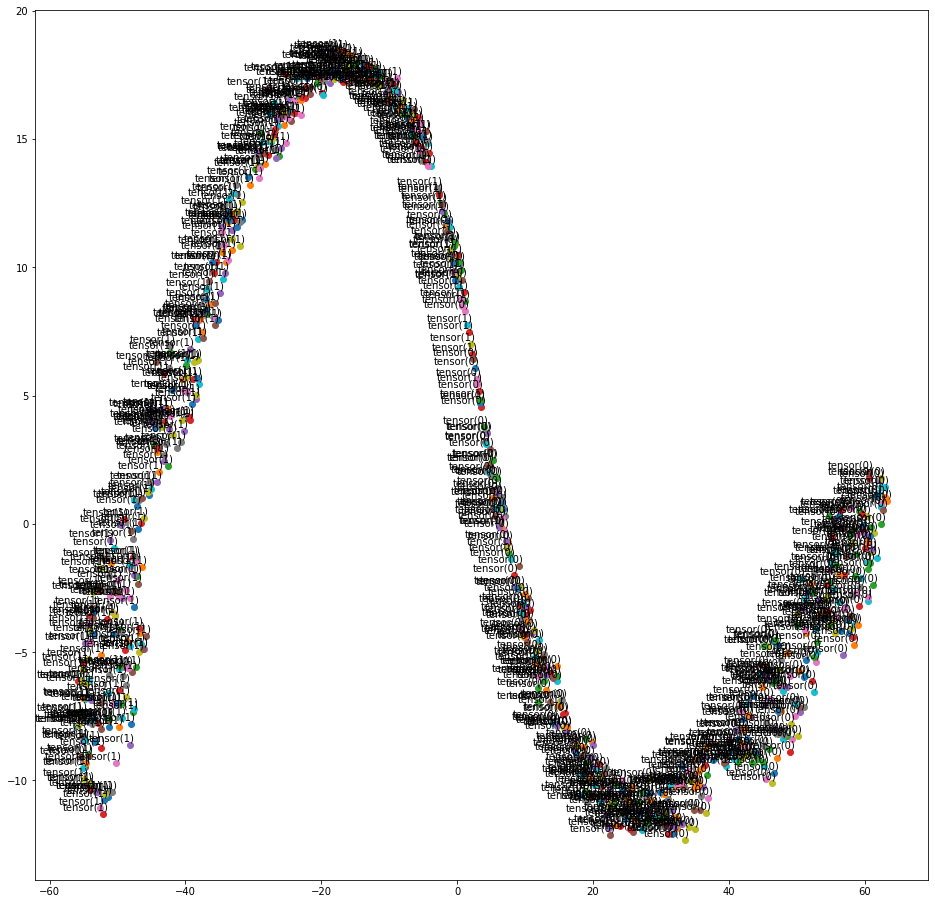

In [21]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(flat_predictions_raw)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()